In [79]:
import os

import random
import numpy as np
import seaborn as sn
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable

from argparse import Namespace

import time

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

from tqdm import notebook

import matplotlib.pyplot as plt

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
args = Namespace(
    dataset_dir = ".data",
    dataset_prefix = "faq_with_splits_",
    datasets = ["tokenized", "filtered", "lemmatized", "stemmed", "lemmatized_filtered", "stemmed_filtered"],
    model_save_dir = ".model_storage/MLP",
    model_state_file = "model",
    seed = 1234,
    num_epochs = 5,
    learning_rate = 1e-3,
    hidden_size = 100,
    batch_size = 128,
    cuda = True,
)

In [5]:
args.model_state_file = os.path.join(args.model_save_dir, args.model_state_file)

In [6]:
if not os.path.exists(args.model_save_dir):
    os.makedirs(args.model_save_dir)
    print(f"Created directory {args.model_save_dir}")
else:
    print(f"{args.model_save_dir} directory already exists")

.model_storage/MLP directory already exists


## Loading datasets

In [7]:
faq_dataframes = {}

for dataset in args.datasets:
    df_path = os.path.join(args.dataset_dir, args.dataset_prefix + dataset + ".csv")
    print(f"Opening file: {df_path}")
    faq_dataframes[dataset] = pd.read_csv(df_path)

Opening file: .data\faq_with_splits_tokenized.csv
Opening file: .data\faq_with_splits_filtered.csv
Opening file: .data\faq_with_splits_lemmatized.csv
Opening file: .data\faq_with_splits_stemmed.csv
Opening file: .data\faq_with_splits_lemmatized_filtered.csv
Opening file: .data\faq_with_splits_stemmed_filtered.csv


In [8]:
faq_dataframes[args.datasets[0]].head()

,short_question,long_question,answer,main_category,sub_category,split
0,Nagy terület őrzésére milyen kutyát javasolnát...,Nagy terület őrzésére milyen kutyát javasolnát...,A komondor/kuvasz páros kimondottan ezekre a f...,Állatok,Kutyák,train
1,Az álllatorvosunkat alig lehet elérni Ez szeri...,Az álllatorvosunkat alig lehet elérni Ez szeri...,Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések,val
2,Huskyval össze lehet szoktatni cicákat,Huskyval össze lehet szoktatni cicákat A cica ...,"Persze, hogy össze lehet.A kutyának az első pi...",Állatok,Kutyák,train
3,Vadászok Vennék egy vizslát hobbi célra de elv...,Vadászok Vennék egy vizslát hobbi célra de elv...,Normál esetben egy jó idegrendszerű kutyát nem...,Állatok,Kutyák,train
4,Elszállásolhatok kutyát panellakásban néhány n...,Elszállásolhatok kutyát panellakásban néhány n...,"Az a házirend rész érvénytelen, amiben ilyent ...",Állatok,Egyéb kérdések,train


## Shuffle each dataset the same way

In [9]:
def shuffle_datasets(datasets, indexes):
    for dataset in datasets:
        datasets[dataset] = datasets[dataset].loc[indexes]
    return datasets

In [10]:
shuffled = faq_dataframes[args.datasets[0]].copy()
shuffled = shuffle(shuffled)
indexes = shuffled.index.values

faq_dataframes = shuffle_datasets(faq_dataframes, indexes)

In [11]:
faq_dataframes[args.datasets[0]].head()

,short_question,long_question,answer,main_category,sub_category,split
91609,Miért nem tudok elélvezni Hiába elégítem ki ma...,Miért nem tudok elélvezni Hiába elégítem ki ma...,"Érdekes. Az első válaszolónak írnám, hogy nem ...",Egészség,Férfiak egészsége,val
139658,Kb 10 12 éve játszottam egy számítógépes játék...,Kadosa István nevű felhasználó kérdése Kb 10 1...,Deer Avenger,Szórakozás,Játékok,test
102002,Ha vírus települt a rendszerbe és újratelepíte...,Ha vírus települt a rendszerbe és újratelepíte...,"Telepítőről bootolva, az ssd-t/hdd-t formázva ...",Számítástechnika,Hardverek,train
82235,Gáz ha tampont akarok használni 13 évesen,Gáz ha tampont akarok használni 13 évesen Most...,"Gáznak nem gáz, de csak akkor használd ha kény...",Egészség,Nők egészsége,train
51281,Lehetséges hogy pszichopata vagyok leszek,Lehetséges hogy pszichopata vagyok leszek Kìvü...,"Aki a kutyáját szereti, rossz ember nem lehet",Egészség,Mentális egészség,train


In [12]:
faq_dataframes[args.datasets[1]].head()

,short_question,long_question,answer,main_category,sub_category,split
91609,Miért tudok elélvezni Hiába elégítem magamat p...,Miért tudok elélvezni Hiába elégítem magamat p...,"Érdekes. Az első válaszolónak írnám, hogy nem ...",Egészség,Férfiak egészsége,val
139658,Kb 10 12 éve játszottam számítógépes játékkal ...,Kadosa István nevű felhasználó kérdése Kb 10 1...,Deer Avenger,Szórakozás,Játékok,test
102002,Ha vírus települt rendszerbe újratelepítem Win...,Ha vírus települt rendszerbe újratelepítem Win...,"Telepítőről bootolva, az ssd-t/hdd-t formázva ...",Számítástechnika,Hardverek,train
82235,Gáz ha tampont akarok használni 13 évesen,Gáz ha tampont akarok használni 13 évesen Most...,"Gáznak nem gáz, de csak akkor használd ha kény...",Egészség,Nők egészsége,train
51281,Lehetséges pszichopata leszek,Lehetséges pszichopata leszek Kìvülről teljese...,"Aki a kutyáját szereti, rossz ember nem lehet",Egészség,Mentális egészség,train


## Seperate datasets by splits

In [13]:
def get_dataframes_for_split(split, datasets):
    return {ds: datasets[ds][datasets[ds].split == split] for ds in datasets}

In [14]:
train_dfs = get_dataframes_for_split('train', faq_dataframes)
test_dfs = get_dataframes_for_split('test', faq_dataframes)
valid_dfs = get_dataframes_for_split('val', faq_dataframes)

In [15]:
train_dfs[args.datasets[0]].head()

,short_question,long_question,answer,main_category,sub_category,split
102002,Ha vírus települt a rendszerbe és újratelepíte...,Ha vírus települt a rendszerbe és újratelepíte...,"Telepítőről bootolva, az ssd-t/hdd-t formázva ...",Számítástechnika,Hardverek,train
82235,Gáz ha tampont akarok használni 13 évesen,Gáz ha tampont akarok használni 13 évesen Most...,"Gáznak nem gáz, de csak akkor használd ha kény...",Egészség,Nők egészsége,train
51281,Lehetséges hogy pszichopata vagyok leszek,Lehetséges hogy pszichopata vagyok leszek Kìvü...,"Aki a kutyáját szereti, rossz ember nem lehet",Egészség,Mentális egészség,train
43535,Úgy általánosságban mely kutyafajták a legvicc...,Úgy általánosságban mely kutyafajták a legvicc...,Én is a boxert ajánlom!Játékos gyerekszerető k...,Állatok,Kutyák,train
151992,Ki az a kakarot,Ki az a kakarot Most nézem a dragon ball gt t ...,"Biztos bezavarhatott, hogy a Dragon Ball Z mag...",Szórakozás,"Filmek, sorozatok",train


## Drop the unnecessary columns
Keeping the following columns:
- main category
- short question
- long question

In [16]:
def keep_columns(datasets, columns):
    return {ds: datasets[ds][columns] for ds in datasets}

In [17]:
columns = ['main_category', 'short_question', 'long_question']

train_dfs = keep_columns(train_dfs, columns)
test_dfs = keep_columns(test_dfs, columns)
valid_dfs = keep_columns(valid_dfs, columns)

In [18]:
train_dfs[args.datasets[0]].head()

,main_category,short_question,long_question
102002,Számítástechnika,Ha vírus települt a rendszerbe és újratelepíte...,Ha vírus települt a rendszerbe és újratelepíte...
82235,Egészség,Gáz ha tampont akarok használni 13 évesen,Gáz ha tampont akarok használni 13 évesen Most...
51281,Egészség,Lehetséges hogy pszichopata vagyok leszek,Lehetséges hogy pszichopata vagyok leszek Kìvü...
43535,Állatok,Úgy általánosságban mely kutyafajták a legvicc...,Úgy általánosságban mely kutyafajták a legvicc...
151992,Szórakozás,Ki az a kakarot,Ki az a kakarot Most nézem a dragon ball gt t ...


#### Get the main categories
Get main category names and assign ids for them

In [19]:
target_names = faq_dataframes[args.datasets[0]].main_category.unique().tolist()
target_dict = {k: v for v, k in enumerate(target_names)}

In [20]:
print(target_names)
print(target_dict)

['Egészség', 'Szórakozás', 'Számítástechnika', 'Állatok']
{'Egészség': 0, 'Szórakozás': 1, 'Számítástechnika': 2, 'Állatok': 3}


### Get vocabulary for bag of words

Which way of getting the vocabulary is faster? The primitive approach, iterating over the dataframe row by row, or the sigma male approach, which takes advantage of the library’s potential. This is a rhetorical question. It could be faster imo, but I'm pleased with this speed.

In [21]:
vocab = set()

start_time = int(time.time() * 1000)

for index, row in train_dfs[args.datasets[0]].iterrows():
    for word in row.short_question.lower().split():
        vocab.add(word)

end_time = int(time.time() * 1000)

print(f"Getting vocabulary primitively took {(end_time - start_time) / 1000.0} seconds")
print(f"Length of vocabulary is {len(vocab)}")

Getting vocabulary primitively took 8.226 seconds
Length of vocabulary is 115231


In [22]:
vocab = set()

start_time = int(time.time() * 1000)

train_dfs[args.datasets[0]].apply(lambda row: vocab.update(row.short_question.lower().split()), axis = 1)

end_time = int(time.time() * 1000)

print(f"Getting vocabulary in style took {(end_time - start_time) / 1000.0} seconds")
print(f"Length of vocabulary is {len(vocab)}")

Getting vocabulary in style took 2.805 seconds
Length of vocabulary is 115231


In [23]:
def get_vocabulary_for_each_dataset(dataframes):
    vocabularies = {}
    
    for dataframe in dataframes:
        start_time = int(time.time() * 1000)
        
        vocab = set()
        
        df = dataframes[dataframe]
        df.apply(lambda row: vocab.update(row.short_question.lower().split()), axis = 1)

        vocabularies[dataframe] = vocab
        
        end_time = int(time.time() * 1000)
        
        print(f"Getting vocabulary for '{dataframe}' dataset " \
                f"took {(end_time - start_time) / 1000.0} seconds, length = {len(vocab)}")

    return vocabularies

In [24]:
vocabularies = get_vocabulary_for_each_dataset(train_dfs)

Getting vocabulary for 'tokenized' dataset took 2.801 seconds, length = 115231
Getting vocabulary for 'filtered' dataset took 2.735 seconds, length = 115212
Getting vocabulary for 'lemmatized' dataset took 2.84 seconds, length = 79671
Getting vocabulary for 'stemmed' dataset took 2.817 seconds, length = 140541
Getting vocabulary for 'lemmatized_filtered' dataset took 2.678 seconds, length = 73660
Getting vocabulary for 'stemmed_filtered' dataset took 2.672 seconds, length = 68589


In [25]:
word = list(vocabularies[args.datasets[0]])[4]
word

'gyökérkezeli'

#### Getting the index for a word

In [26]:
def create_index_of_word(vocabularies):
    index_of_word = {}
    for dataset_key in vocabularies:
        index_of_word[dataset_key] = {value: key for key, value in enumerate(vocabularies[dataset_key])}
    return index_of_word

In [27]:
index_of_word = create_index_of_word(vocabularies)

In [28]:
idx = index_of_word[args.datasets[0]][word]
idx

4

### Get a batch of sentences

In [29]:
def get_batch(df, i, batch_size, input_size, index_of_word):

    batches = []
    results = []
    
    current_df = df[i * batch_size : (i + 1) * batch_size]
    
    questions = current_df.short_question.tolist()
    categories = current_df.main_category.tolist()
        
    for text in questions:
        layer = np.zeros(input_size, dtype=float)
        words = text.split()
        
        for word in words:
            if word in index_of_word:
                layer[index_of_word[word]] += 1
            
        batches.append(layer)
        
    results = [target_dict[category] for category in categories]
     
    return np.array(batches), np.array(results)

## Multilayer Perceptron

In [30]:
class MLP(nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True)
 
     def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

In [31]:
def class_accuracy(prediction, actual):
    rounded_predictions = prediction.argmax(1)
    correct = (rounded_predictions == actual).float()

    acc = correct.sum() / len(correct)
    return acc

In [32]:
def train_model(model, train_dataframe, vocabulary, index_of_word, optimizer, criterion, bar):

    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    total_batch = len(train_dataframe) // args.batch_size

    for i in range(total_batch):
        batch_input, batch_target = get_batch(train_dataframe, i, args.batch_size, len(vocabulary), index_of_word)
        
        batch_input = Variable(torch.FloatTensor(batch_input))
        batch_target = Variable(torch.LongTensor(batch_target))

        optimizer.zero_grad()
        
        predictions = model(batch_input)
        loss = criterion(predictions, batch_target)
        acc = class_accuracy(predictions, batch_target)

        loss.backward()

        optimizer.step()
    
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        bar.set_postfix(loss=(epoch_loss / (i + 1)), acc=(epoch_acc / (i + 1)))
        bar.update()

    return epoch_loss / total_batch, epoch_acc / total_batch

In [33]:
def evaluate_model(model, dataframe, vocabulary, index_of_word, optimizer, criterion, bar):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()

    total_predicted = []

    total_batch = len(dataframe) // args.batch_size
    
    with torch.no_grad():
        for i in range(total_batch):
            batch_input, batch_target = get_batch(dataframe, i, args.batch_size, len(vocabulary), index_of_word)
            
            batch_input = Variable(torch.FloatTensor(batch_input))
            batch_target = Variable(torch.LongTensor(batch_target))
            
            predictions = model(batch_input)
            loss = criterion(predictions, batch_target)
            acc = class_accuracy(predictions, batch_target)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            _, predicted = torch.max(predictions.data, 1)
            total_predicted += predicted.tolist()
            
            bar.set_postfix(loss=epoch_loss / (i + 1), acc=epoch_acc / (i + 1))
            bar.update()
            
    return epoch_loss / total_batch, epoch_acc / total_batch, total_predicted

In [34]:
train_losses = {}
train_accuracies = {}

valid_losses = {}
valid_accuracies = {}

for dataset_key in args.datasets:
    best_valid_loss = float('inf')

    train_losses[dataset_key] = []
    train_accuracies[dataset_key] = []

    valid_losses[dataset_key] = []
    valid_accuracies[dataset_key] = []
    
    train_df = train_dfs[dataset_key]
    valid_df = valid_dfs[dataset_key]
    vocabulary = vocabularies[dataset_key]
    index_of_word_ = index_of_word[dataset_key]

    model = MLP(len(vocabulary), args.hidden_size, len(target_names))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()  
    criterion = criterion.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)
    
    train_size = train_df.shape[0] // args.batch_size
    valid_size = valid_df.shape[0] // args.batch_size
    
    epoch_bar = notebook.tqdm(desc=f"'{dataset_key}' epoch", total=args.num_epochs, position=0, leave=True)
    train_bar = notebook.tqdm(desc=f"'{dataset_key}' train", total=train_size, position=1, leave=True)
    valid_bar = notebook.tqdm(desc=f"'{dataset_key}' valid",total=valid_size, position=1, leave=True)
    
    for epoch in range(args.num_epochs):
        train_bar.n = 0
        valid_bar.n = 0

        train_bar.refresh()
        valid_bar.refresh()

        train_loss, train_acc = train_model(model, train_df, vocabulary, index_of_word_, optimizer, criterion, train_bar)
        valid_loss, valid_acc, _ = evaluate_model(model, valid_df, vocabulary, index_of_word_, optimizer, criterion, valid_bar)
    
        train_losses[dataset_key].append(train_loss)
        train_accuracies[dataset_key].append(train_acc)

        valid_losses[dataset_key].append(valid_loss)
        valid_accuracies[dataset_key].append(valid_acc)
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), args.model_state_file + "_" + dataset_key + ".pth")

        epoch_bar.update()
        epoch_bar.refresh()

'tokenized' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'tokenized' train:   0%|          | 0/839 [00:00<?, ?it/s]

'tokenized' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'filtered' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'filtered' train:   0%|          | 0/839 [00:00<?, ?it/s]

'filtered' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'lemmatized' train:   0%|          | 0/839 [00:00<?, ?it/s]

'lemmatized' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'stemmed' train:   0%|          | 0/839 [00:00<?, ?it/s]

'stemmed' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized_filtered' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'lemmatized_filtered' train:   0%|          | 0/839 [00:00<?, ?it/s]

'lemmatized_filtered' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed_filtered' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'stemmed_filtered' train:   0%|          | 0/839 [00:00<?, ?it/s]

'stemmed_filtered' valid:   0%|          | 0/179 [00:00<?, ?it/s]

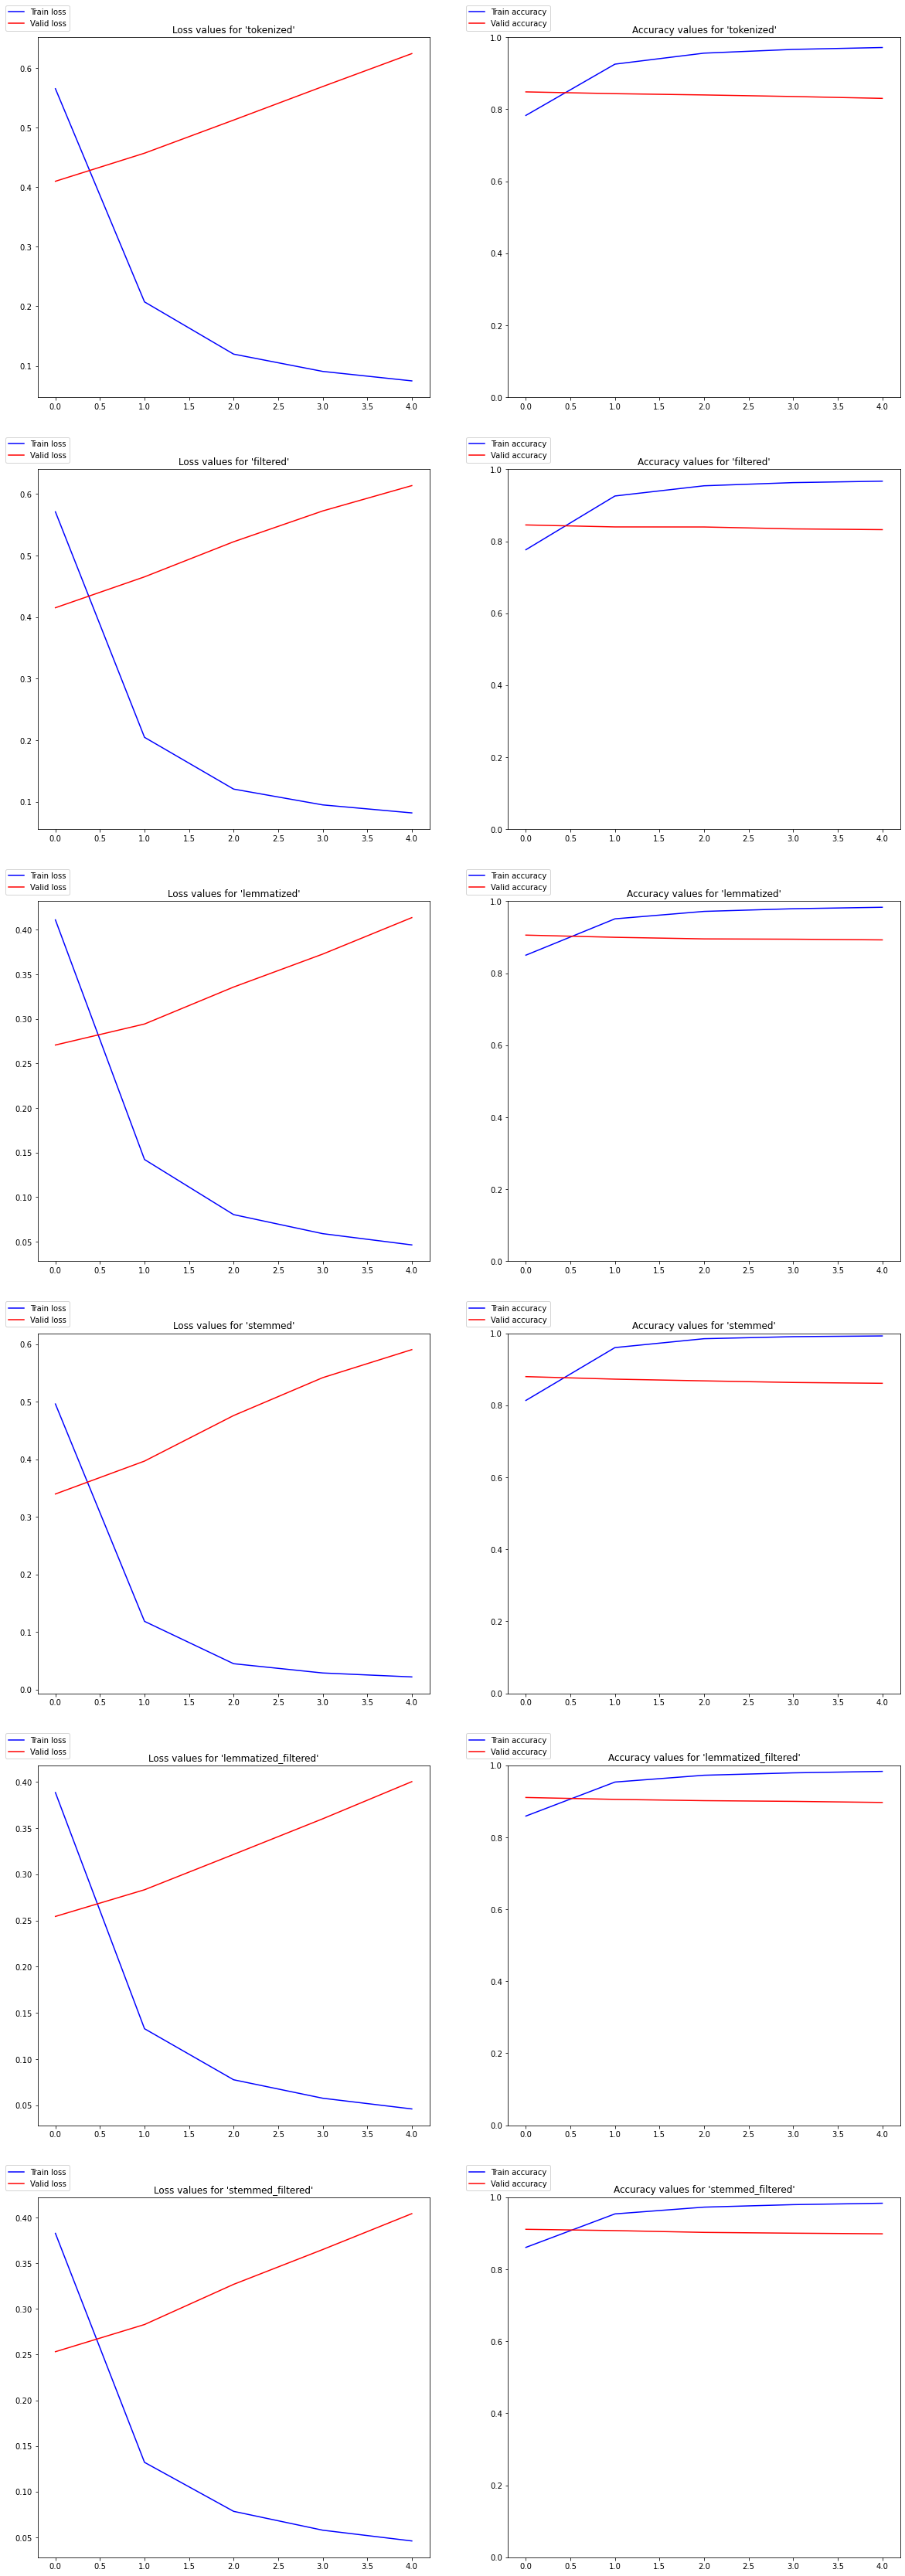

In [47]:
fig, axs = plt.subplots(len(args.datasets), 2, figsize=(10 * 2, 10 * len(args.datasets)))

for idx, dataset in enumerate(args.datasets):
    axs[idx, 0].set_title(f"Loss values for '{dataset}'")
    axs[idx, 0].plot([*range(args.num_epochs)], train_losses[dataset], color = 'b', label='Train loss')
    axs[idx, 0].plot([*range(args.num_epochs)], valid_losses[dataset], color = 'r', label='Valid loss')
    axs[idx, 0].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)
    
    axs[idx, 1].set_title(f"Accuracy values for '{dataset}'")
    axs[idx, 1].axis(ymin = 0, ymax = 1)
    axs[idx, 1].plot([*range(args.num_epochs)], train_accuracies[dataset], color = 'b', label='Train accuracy')
    axs[idx, 1].plot([*range(args.num_epochs)], valid_accuracies[dataset], color = 'r', label='Valid accuracy')
    axs[idx, 1].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)
    
plt.show()

In [56]:
predictions = {}
number_of_batches = 0

for dataset_key in args.datasets:
    test_df = test_dfs[dataset_key]
   
    vocabulary = vocabularies[dataset_key]
    index_of_word_ = index_of_word[dataset_key]
    
    test_size = test_df.shape[0] // args.batch_size
    test_bar = notebook.tqdm(desc=f"'{dataset_key}' test", total=test_size, position=1, leave=True)

    model = MLP(len(vocabulary), args.hidden_size, len(target_names))
    model.load_state_dict(torch.load(args.model_state_file + "_" + dataset_key + ".pth"))
    _, _, predictions[dataset_key] = evaluate_model(model, test_df, vocabulary, index_of_word_, optimizer, criterion, test_bar)

'tokenized' test:   0%|          | 0/179 [00:00<?, ?it/s]

'filtered' test:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized' test:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed' test:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized_filtered' test:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed_filtered' test:   0%|          | 0/179 [00:00<?, ?it/s]

In [59]:
test_target = test_dfs[args.datasets[0]].main_category.apply(lambda x: target_dict[x]).tolist()

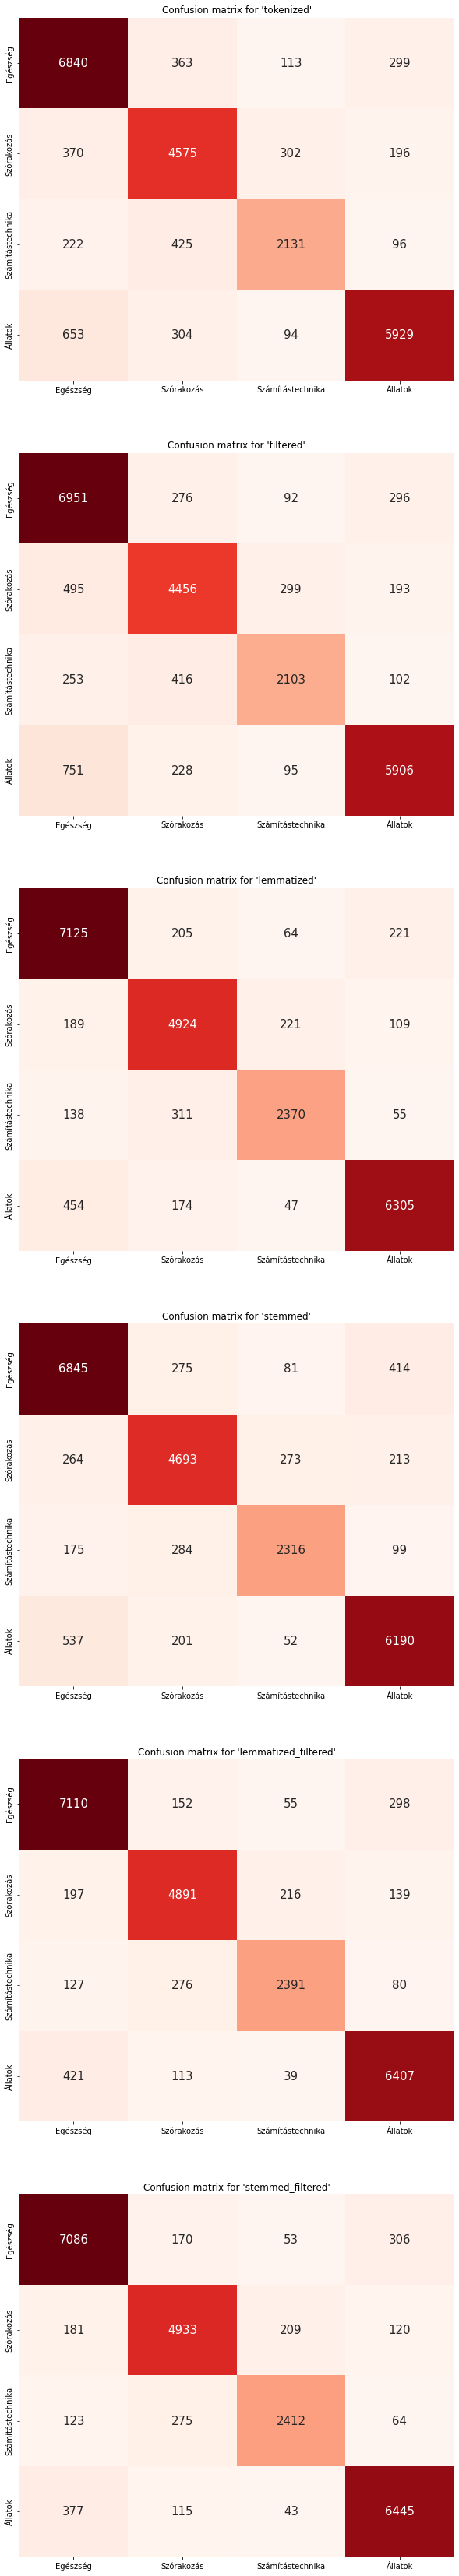

In [76]:
fig, axs = plt.subplots(len(args.datasets), 1, figsize=(10 * 1, 10 * len(args.datasets)))

for idx, dataset_key in enumerate(args.datasets):
    axs[idx].set_title(f"Confusion matrix for '{dataset_key}'")
    
    pred = predictions[dataset_key]
    
    cm = confusion_matrix(test_target[:len(pred)], pred)
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    
    heatmap = sn.heatmap(cm_df, annot=True, ax=axs[idx], cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)

plt.show()

In [81]:
for dataset_key in args.datasets:
    pred = predictions[dataset_key]
    report = classification_report(test_target[:len(pred)], pred, target_names=target_names)
    print(f"Classification report for '{dataset_key}':\n{report}\n{'=' * 100}")

Classification report for 'tokenized':
                  precision    recall  f1-score   support

        Egészség       0.85      0.90      0.87      7615
      Szórakozás       0.81      0.84      0.82      5443
Számítástechnika       0.81      0.74      0.77      2874
         Állatok       0.91      0.85      0.88      6980

        accuracy                           0.85     22912
       macro avg       0.84      0.83      0.84     22912
    weighted avg       0.85      0.85      0.85     22912

Classification report for 'filtered':
                  precision    recall  f1-score   support

        Egészség       0.82      0.91      0.87      7615
      Szórakozás       0.83      0.82      0.82      5443
Számítástechnika       0.81      0.73      0.77      2874
         Állatok       0.91      0.85      0.88      6980

        accuracy                           0.85     22912
       macro avg       0.84      0.83      0.83     22912
    weighted avg       0.85      0.85      0.85 